In [16]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
from sklearn.experimental import enable_iterative_imputer
import napari
from sklearn.impute import IterativeImputer
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



# Plot a neuron with gaps and incorrects IDs

In [3]:
opt = dict(channel_mode='ratio',
          calculation_mode='integration',
          neuron_name='neuron_001')

Text(0.5, 1.0, 'min_confidence = 0.0')

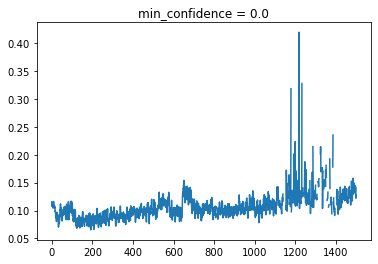

In [5]:
y = project_data.calculate_traces(**opt, min_confidence=0.0)

%matplotlib inline
plt.plot(y)
plt.title("min_confidence = 0.0")

Text(0.5, 1.0, 'min_confidence = 0.5')

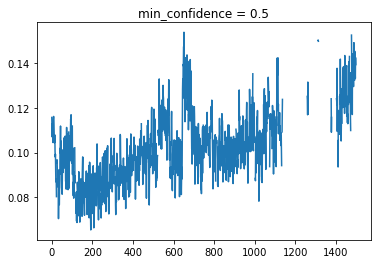

In [6]:
y = project_data.calculate_traces(**opt, min_confidence=0.5)

%matplotlib inline
plt.plot(y)
plt.title("min_confidence = 0.5")

# Plot the spatial locations of the gap

In [9]:
gap_ind = np.arange(1100, 1200)
df_raw = project_data.red_traces

In [10]:
df_raw['neuron_001'].iloc[1135:1140]

,area,z,x,y,intensity_image,label
1135,559.0,6.086713,161.061959,342.413510,13412.0,1.0
1136,567.0,6.388455,159.131504,365.941838,13703.0,1.0
1137,566.0,5.078241,163.230561,399.790941,14417.0,1.0
1138,750.0,5.784752,186.746353,447.087865,17891.0,1.0
1139,NaN,NaN,NaN,NaN,NaN,NaN


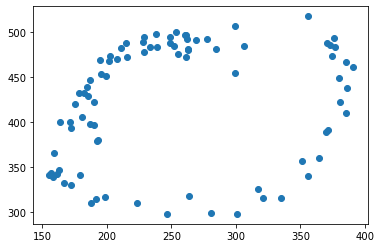

In [11]:
%matplotlib inline
x = df_raw['neuron_001']['x'].iloc[gap_ind]
y = df_raw['neuron_001']['y'].iloc[gap_ind]
plt.plot(x, y, 'o')

# Impute the location of this neuron for the gaps: with posterior sampling

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import filter_dataframe_using_likelihood
from DLC_for_WBFM.utils.postprocessing.utils_imputation import df_of_only_locations, scale_impute_descale

In [13]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [14]:
df_raw = project_data.final_tracks
df_with_likelihood = df_raw.copy()

likelihood_thresh = 0.5
df_filter = filter_dataframe_using_likelihood(df_with_likelihood, likelihood_thresh)

  0%|          | 0/120 [00:00<?, ?it/s]

In [17]:
df_only_locations, old2new_names = df_of_only_locations(df_filter)

In [26]:

def __scale_impute_descale(df_only_locations, n_nearest_features=20):
    df_dat = df_only_locations.to_numpy()
    
    imputer = IterativeImputer(random_state=0, 
                               missing_values=np.nan, 
                               verbose=2, 
                               n_nearest_features=n_nearest_features, 
                               max_iter=3,
                               sample_posterior=True)
    scaler = StandardScaler()
    scaler.fit(df_dat)
    dat_normalized = scaler.transform(df_dat)

    imputer.fit(dat_normalized)
    
    dat_sklearn = scaler.inverse_transform(imputer.transform(dat_normalized))
    df_sklearn = pd.DataFrame(data=dat_sklearn, columns=df_only_locations.columns)
    
    return df_sklearn, scaler, imputer

In [27]:
df_sklearn, scaler, imputer = __scale_impute_descale(df_only_locations, 10)

[IterativeImputer] Completing matrix with shape (1500, 360)
[IterativeImputer] Ending imputation round 1/3, elapsed time 58.44
[IterativeImputer] Ending imputation round 2/3, elapsed time 116.67
[IterativeImputer] Ending imputation round 3/3, elapsed time 176.75
[IterativeImputer] Completing matrix with shape (1500, 360)
[IterativeImputer] Ending imputation round 1/3, elapsed time 45.24
[IterativeImputer] Ending imputation round 2/3, elapsed time 90.58
[IterativeImputer] Ending imputation round 3/3, elapsed time 135.57


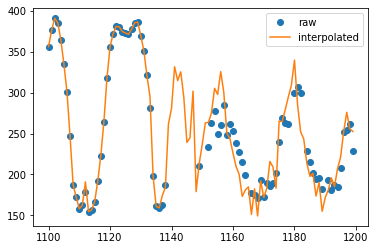

In [28]:
%matplotlib inline
gap_ind = np.arange(1100, 1200)

x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_sklearn['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

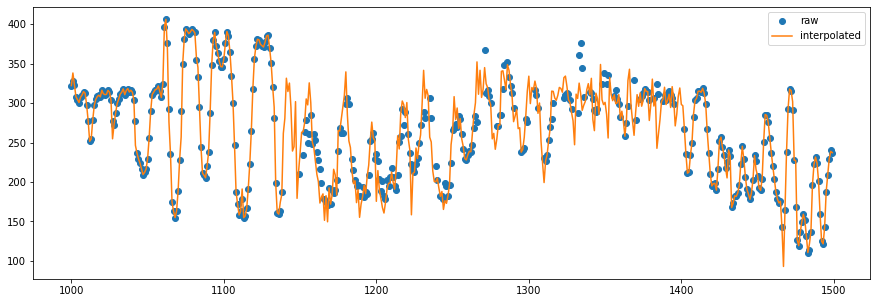

In [33]:
%matplotlib inline
gap_ind = np.arange(1000, 1500)

plt.figure(figsize=(15,5))
x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_sklearn['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

In [333]:
# Just replace one column: neuron 001
# new2old_names = {v: k for k, v in old2new_names.items()}

old_names_to_update = [
    ('neuron_001', 'z'),
    ('neuron_001', 'x'),
    ('neuron_001', 'y'),
]

df_interp = df_raw.copy()

for n in old_names_to_update:
    df_interp[n] = df_sklearn[old2new_names[n]]

In [334]:
# %matplotlib widget
# gap_ind = np.arange(1100, 1200)

# x = df_raw['neuron_001']['x'].iloc[gap_ind]
# plt.plot(x, 'o', label='raw')
# x = df_interp['neuron_001']['x'].iloc[gap_ind]
# plt.plot(x, label='interpolated')
# plt.legend()

# Try 2: no posterior sampling

In [82]:
df_sklearn2 = scale_impute_descale(df_only_locations, 100)

[IterativeImputer] Completing matrix with shape (1500, 360)
[IterativeImputer] Change: 333.590037757923, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 79.53310548065582, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 70.46853937877385, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 69.70950847923476, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 70.5749603330831, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 58.89936023778804, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 55.95359145961167, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 51.265915505093396, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 59.29966977466772, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 61.30023966970357, scaled tolerance: 0.008253465104401848 
[IterativeImputer] Change: 54.45418004201881, scaled tolerance: 0.008253465104401

/home/user/fieseler/.conda/envs/segmentation/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


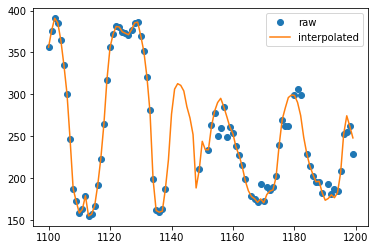

In [83]:
%matplotlib inline
gap_ind = np.arange(1100, 1200)

x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_sklearn2['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

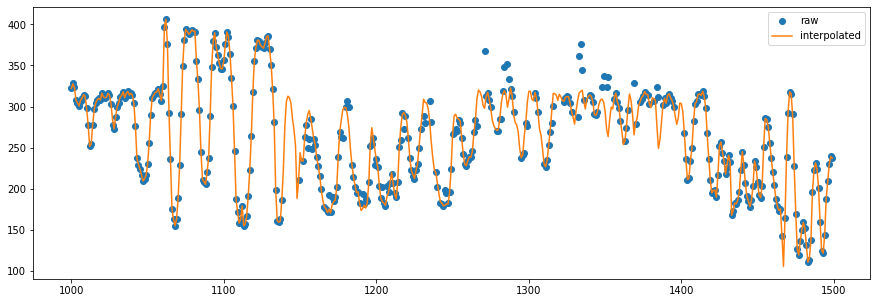

In [84]:
%matplotlib inline
gap_ind = np.arange(1000, 1500)

plt.figure(figsize=(15,5))
x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_sklearn2['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

In [220]:
# Just replace one column: neuron 001
# new2old_names = {v: k for k, v in old2new_names.items()}
which_neuron = 'neuron_001'
coords = ['z', 'x', 'y']

old_names_to_update = [(which_neuron, c) for c in coords]

df_interp2 = df_raw.copy()

for n in old_names_to_update:
    df_interp2[n] = df_sklearn2[old2new_names[n]]

In [184]:
# df_sklearn2

In [185]:
# How far away is the closest neuron?
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

num_frames = 1500
# which_neuron = 'neuron_003'
all_imp_dist, all_raw_dist = [], []

for i_frame in tqdm(range(num_frames)):

    segmented_pts = project_data.get_centroids_as_numpy(i_frame)
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(segmented_pts)

    coords = ['z', 'x', 'y']

    # Get points
    imputed_pt = df_interp2[which_neuron].iloc[i_frame].to_numpy()[:3]

    compound_names = [f"{which_neuron}_{c}" for c in coords]
    raw_pt = [df_filter[c].iloc[i_frame] for c in compound_names]
    if any(np.isnan(raw_pt)):
        is_imputed = True
    else:
        is_imputed = False
#     print(imputed_pt, raw_pt)

    # Get closest neighbor
    if not any(np.isnan(imputed_pt)):
        imputed_dist, _ = nbrs.kneighbors([imputed_pt], n_neighbors=1)
        all_imp_dist.append(imputed_dist[0][0])
    else:
        all_imp_dist.append(np.nan)
    if not is_imputed:
        raw_dist, _ = nbrs.kneighbors([raw_pt], n_neighbors=1)
        all_raw_dist.append(raw_dist[0][0])
#         print(imputed_dist, raw_dist)
    else:
        all_raw_dist.append(np.nan)
#         print("Raw is nan")
#         print(imputed_dist)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [223]:
from DLC_for_WBFM.utils.postprocessing.utils_imputation import get_distance_to_closest_neurons_over_time

all_dist_sklearn = get_distance_to_closest_neurons_over_time(project_data, 'neuron_001', df_interp2)

  0%|          | 0/1500 [00:00<?, ?it/s]

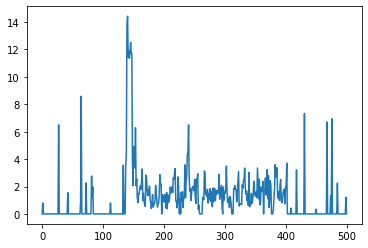

In [224]:

gap_ind = np.arange(1000, 1500)
plt.plot(all_dist_sklearn[gap_ind])

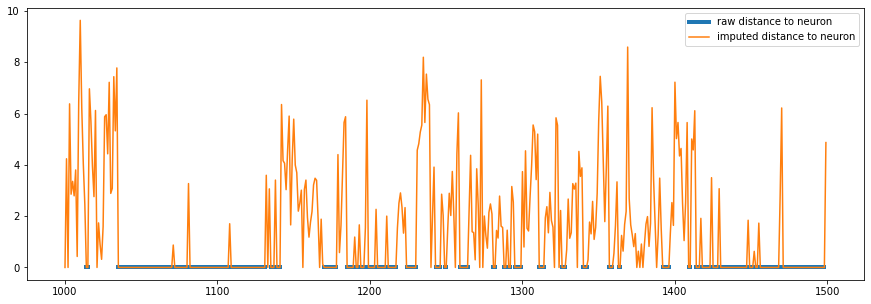

In [186]:
%matplotlib inline
gap_ind = np.arange(1000, 1500)

plt.figure(figsize=(15,5))
plt.plot(gap_ind, np.array(all_raw_dist)[gap_ind], label='raw distance to neuron', lw=4)
plt.plot(gap_ind, np.array(all_imp_dist)[gap_ind], label='imputed distance to neuron')
plt.legend()

In [181]:
all_imp_dist[1140]

0.0

# Get tracklet that's close to the point

In [128]:
df_tracklets = project_data.df_all_tracklets

In [176]:
i_time = 1183
which_neuron = 'neuron_001'
target_pt = df_interp2[which_neuron].iloc[i_time][:3]
all_tracklet_names = list(df_tracklets.columns.levels[0])

if any(np.isnan(target_pt)):
    print("Target is nan")
else:
    all_zxy = np.reshape(df_tracklets.iloc[i_time, :].to_numpy(), (-1, 4))
    all_zxy = all_zxy[~np.isnan(all_zxy).any(axis=1)][:, :3]
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(all_zxy)
    dist, ind = nbrs.kneighbors([target_pt], n_neighbors=1)
    close_name = all_tracklet_names[ind[0][0]]

    print(f"Closest to tracklet {close_name} at distance {dist[0][0]}")

Closest to tracklet neuron0 at distance 0.6470188757168978


In [171]:
target_pt

z      7.625314
x    276.295780
y    509.428721
Name: 1140, dtype: float64

# Debug the functions

In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-imputation/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-imputation 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: False
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: False
green_traces: False
final_tracks: True
behavior_annotations: True



In [36]:
from DLC_for_WBFM.utils.postprocessing.utils_imputation import impute_tracks_from_config, _unpack_for_imputing
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import filter_dataframe_using_likelihood
from DLC_for_WBFM.utils.projects.utils_filepaths import pickle_load_binary
import os

track_cfg = project_data.project_config.get_tracking_config()

In [37]:
impute_tracks_from_config(track_cfg)

  0%|          | 0/120 [00:00<?, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


[IterativeImputer] Completing matrix with shape (1500, 357)
[IterativeImputer] Change: 347.33312896470534, scaled tolerance: 0.008285107952532482 


KeyboardInterrupt: 

In [38]:
df_raw, fname, likelihood_thresh, n_nearest_features = _unpack_for_imputing(track_cfg)

In [39]:
df_filter = filter_dataframe_using_likelihood(df_raw, likelihood_thresh)

  0%|          | 0/120 [00:00<?, ?it/s]

In [65]:
[((i+1)//4, c) for i, c in enumerate(df_raw.count()) if c < 5]

[(103, 0), (103, 0), (103, 0), (118, 2), (118, 2), (118, 2)]

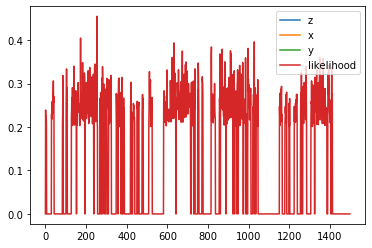

In [67]:
df_raw['neuron_104'].plot()

# Debug the tracklet matching

In [4]:
fname = os.path.join(project_data.project_dir, '3-tracking', 'global2tracklet.pickle')
matches = pickle_load_binary(fname)

In [68]:
raw_name = 'neuron_104'
matches[raw_name]

[1820,
 10301,
 6421,
 7536,
 2166,
 10502,
 6291,
 9444,
 6545,
 7731,
 6159,
 7771,
 5923,
 2617,
 12045,
 1630,
 6255,
 11586,
 10163,
 7443,
 11315,
 6947,
 3133,
 3047,
 10035,
 7074,
 575,
 11950,
 6862,
 135,
 3228,
 2034,
 11903,
 619,
 487,
 2701,
 7129,
 3790,
 3558,
 3974,
 8767,
 11361,
 7962,
 8196,
 4866,
 5153,
 2359,
 246,
 8117,
 5504,
 299,
 10935,
 12090]

In [6]:
df_tracklets = project_data.df_all_tracklets

In [69]:
tracklet_names = df_tracklets.columns.levels[0]

i = 1820
name = tracklet_names[i]

df_tracklets[name].count()

coords
z             15
x             15
y             15
likelihood    15
dtype: int64

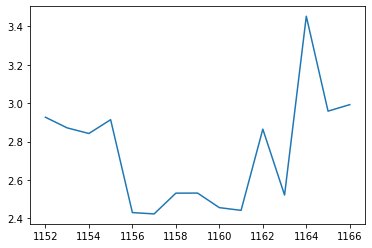

In [71]:
df_tracklets[name]['z'].plot()

tracklet_ind = [1150, 1170]

In [43]:
# df_raw['neuron_002'].iloc[550: 600]
# plt.xlim([20,50])

In [27]:
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import combine_global_and_tracklet_coverings
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

final_track_df, new_tracklet_df = combine_global_and_tracklet_coverings(matches, df_tracklets, [], True, verbose=2)

DEBUG:root:test
INFO:root:Found 120 tracklet-track combinations
INFO:root:Found 6 tracklets for neuron_001
INFO:root:Matching neuron neuron_001 with tracklets ['neuron41', 'neuron11588', 'neuron14397', 'neuron1517', 'neuron10940', 'neuron15207']
INFO:root:summed_tracklet_array: [10.44309392 10.44420601  9.07940447 ...  9.38860104  8.40604027
  8.19336219]
INFO:root:Nonzero entries: (array([   0,    1,    2, ..., 1496, 1497, 1498]),)
INFO:root:Found 5 tracklets for neuron_002
INFO:root:Matching neuron neuron_002 with tracklets ['neuron5836', 'neuron4888', 'neuron766', 'neuron15075', 'neuron7904']
INFO:root:summed_tracklet_array: [0.         0.         0.         ... 7.98859935 7.93181818 7.4375    ]
INFO:root:Nonzero entries: (array([  46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,  444,  445,  4

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


(1150, 1170)

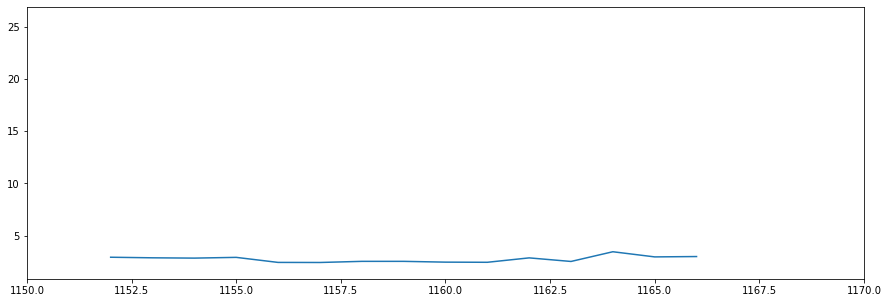

In [75]:
%matplotlib inline
plt.figure(figsize=(15,5))
final_track_df[raw_name]['z'].replace(0.0, np.nan).plot()
plt.xlim(tracklet_ind)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


(1150, 1170)

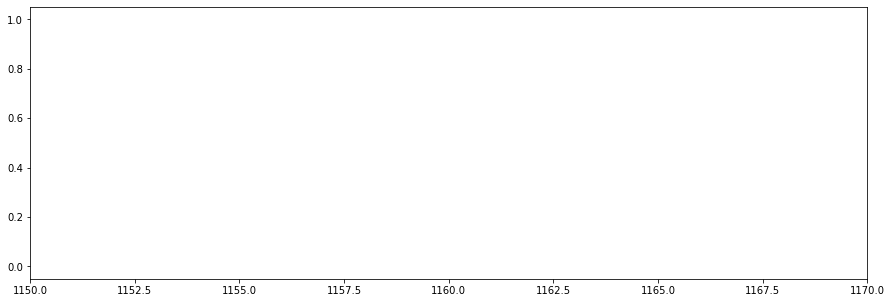

In [76]:
%matplotlib inline
plt.figure(figsize=(15,5))
df_raw[raw_name]['z'].replace(0.0, np.nan).plot()
plt.xlim(tracklet_ind)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


(1150, 1170)

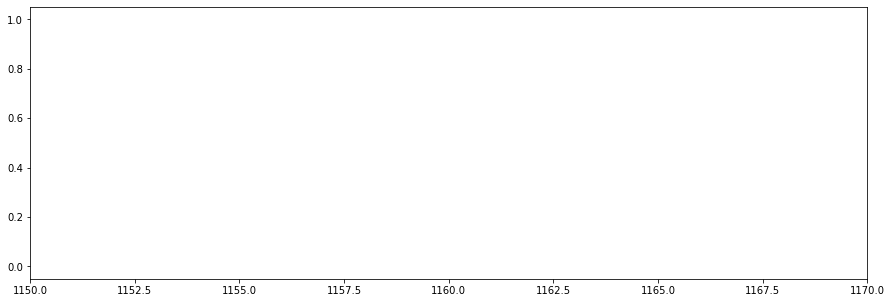

In [77]:
%matplotlib inline
plt.figure(figsize=(15,5))
df_filter[raw_name]['z'].replace(0.0, np.nan).plot()
plt.xlim(tracklet_ind)

# Try 3: fancy imputation package

In [228]:
from fancyimpute import IterativeSVD, SoftImpute

In [229]:

def __scale_imputeSVD_descale(df_only_locations, rank=20):
    df_dat = df_only_locations.to_numpy()
    
    imputer = SoftImpute(max_rank=rank, verbose=True)
    scaler = StandardScaler()
    scaler.fit(df_dat)
    dat_normalized = scaler.transform(df_dat)

    dat_impute = imputer.fit_transform(dat_normalized)
    dat_impute = scaler.inverse_transform(dat_impute)
    df_impute = pd.DataFrame(data=dat_impute, columns=df_only_locations.columns)
    
    return df_impute, scaler, imputer

In [230]:
df_impute, scaler, imputer = __scale_imputeSVD_descale(df_only_locations, 20)

[SoftImpute] Max Singular Value of X_init = 232.853572
[SoftImpute] Iter 1: observed MAE=0.350787 rank=20
[SoftImpute] Iter 2: observed MAE=0.273910 rank=20
[SoftImpute] Iter 3: observed MAE=0.243554 rank=20
[SoftImpute] Iter 4: observed MAE=0.228307 rank=20
[SoftImpute] Iter 5: observed MAE=0.219627 rank=20
[SoftImpute] Iter 6: observed MAE=0.213348 rank=20
[SoftImpute] Iter 7: observed MAE=0.209168 rank=20
[SoftImpute] Iter 8: observed MAE=0.205839 rank=20
[SoftImpute] Iter 9: observed MAE=0.203140 rank=20
[SoftImpute] Iter 10: observed MAE=0.200139 rank=20
[SoftImpute] Iter 11: observed MAE=0.198408 rank=20
[SoftImpute] Iter 12: observed MAE=0.196659 rank=20
[SoftImpute] Iter 13: observed MAE=0.195765 rank=20
[SoftImpute] Iter 14: observed MAE=0.194151 rank=20
[SoftImpute] Iter 15: observed MAE=0.193607 rank=20
[SoftImpute] Iter 16: observed MAE=0.193457 rank=20
[SoftImpute] Iter 17: observed MAE=0.192111 rank=20
[SoftImpute] Iter 18: observed MAE=0.191417 rank=20
[SoftImpute] Iter 

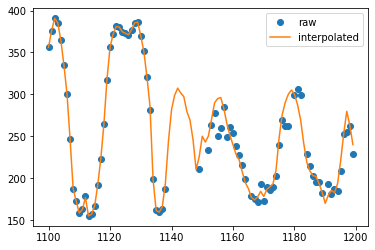

In [231]:
%matplotlib inline
gap_ind = np.arange(1100, 1200)

x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_impute['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

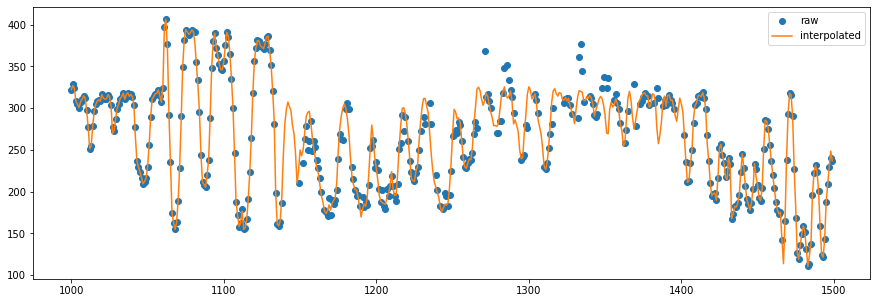

In [232]:
%matplotlib inline
gap_ind = np.arange(1000, 1500)

plt.figure(figsize=(15,5))
x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_impute['neuron_001_x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

In [233]:
# Just replace one column: neuron 001
# new2old_names = {v: k for k, v in old2new_names.items()}

old_names_to_update = [
    ('neuron_001', 'z'),
    ('neuron_001', 'x'),
    ('neuron_001', 'y'),
]

df_interp3 = df_raw.copy()

for n in old_names_to_update:
    df_interp3[n] = df_impute[old2new_names[n]]

In [234]:
from DLC_for_WBFM.utils.postprocessing.utils_imputation import get_distance_to_closest_neurons_over_time

all_dist_SVD = get_distance_to_closest_neurons_over_time(project_data, 'neuron_001', df_interp3)

  0%|          | 0/1500 [00:00<?, ?it/s]

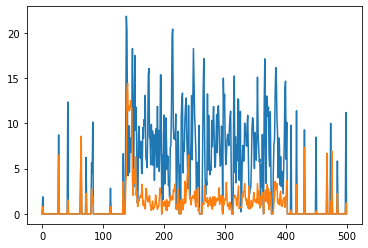

In [235]:
gap_ind = np.arange(1000, 1500)
plt.plot(all_dist_SVD[gap_ind], label='SVD imputed')
plt.plot(all_dist_sklearn[gap_ind], label='sklearn imputed')

# Visualize using napari

In [335]:
from DLC_for_WBFM.gui.utils.napari_trace_explorer import napari_trace_explorer, napari_trace_explorer_from_config
%gui qt

In [336]:
# Use the interpolated tracks

project_data.final_tracks = df_interp
napari_trace_explorer(project_data, False)

Starting GUI setup
Finished loading data, starting napari...


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/charles/a

Finished GUI setup


# Impute, but add time 

In [109]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import filter_dataframe_using_likelihood

In [307]:
fname = "../project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
.. 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [308]:
df_raw = project_data.final_tracks.copy()
df_with_likelihood = df_raw.copy()

likelihood_thresh = 0.5
df_filter = filter_dataframe_using_likelihood(df_with_likelihood, likelihood_thresh)

  0%|          | 0/120 [00:00<?, ?it/s]

In [329]:
def df_of_only_locations(df_raw):
    old_names = df_raw.columns.to_flat_index()
    old2new_names = {a: "_".join(a) for a in old_names}
    new_names = [old2new_names[n] for n in old_names]
    df_filter.columns = new_names
    def name_to_keep(c):
        return ('likelihood' not in c.lower()) and ('intensity' not in c.lower()) and ('label' not in c.lower()) and ('area' not in c.lower())
    to_keep = [c for c in df_filter.columns if name_to_keep(c)]
    df_only_locations = df_filter[to_keep].copy()
    
    return df_only_locations, old2new_names


def takens_embedding(data, dimension, delay=1, append_dim=0):
    """
    This function returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)
    
    The first n columns start at index 0 and end early; the last n columns end at the final index
    """
    # From: https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')
    def get_final_index(i):
        return len(data) - delay*(dimension-i) + 1
    embedded_data = np.array([data[0:get_final_index(0)]])
    for i in range(1, dimension):
        embedded_data = np.append(embedded_data, [data[i*delay:get_final_index(i)]], axis=append_dim)
    return embedded_data


In [310]:
df_only_locations, old2new_names = df_of_only_locations(df_filter)

In [311]:
embedding_dimension = 3
dat_embedded = takens_embedding(df_only_locations, dimension=embedding_dimension, append_dim=-1)[0]
dat_embedded.shape, df_only_locations.shape

((1498, 1080), (1500, 360))

In [312]:
df_only_locations['neuron_001_z'][:3], dat_embedded[:3,0]

(0    10.443094
 1    10.444206
 2     9.079404
 Name: neuron_001_z, dtype: float64,
 array([10.44309392, 10.44420601,  9.07940447]))

In [313]:
def get_suffix(i, base_names):
    # Assumes embedding of 3 and 120 neurons
    i_mod = i % (120*3)
    base_name = base_names[i_mod]
    if i < 360:
        suffix = "m1" # Minus one
    elif i < 720:
        suffix = "p0"
    elif i < 1080:
        suffix = "p1"
    return base_name, suffix

base_names = list(df_only_locations.columns)
embedded_names = [f"{get_suffix(i,base_names)[0]}_{get_suffix(i,base_names)[1]}" for i in range(3*len(base_names))]
len(base_names), len(embedded_names)

(360, 1080)

In [314]:
df_embedded = pd.DataFrame(data=dat_embedded, columns=embedded_names)
# df_embedded

In [316]:
%%time

df_sklearn = scale_impute_descale(df_embedded)

[IterativeImputer] Completing matrix with shape (1498, 1080)
[IterativeImputer] Change: 731.4690436141002, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 366.1738648016339, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 318.03257429968374, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 303.26809050251507, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 283.4533247452771, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 267.8153233099946, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 264.49882297002483, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 261.73057660954186, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 273.36888217011756, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 265.7524306166533, scaled tolerance: 0.008265908899858938 
[IterativeImputer] Change: 271.01548871812656, scaled tolerance: 0.0082659

/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
%matplotlib widget
gap_ind = np.arange(1100, 1200)

x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(gap_ind, x, 'o', label='raw')
x = df_sklearn['neuron_001_x_p0'].iloc[gap_ind-1]
plt.plot(gap_ind, x, label='interpolated')
plt.legend()

In [317]:
# df_sklearn['neuron_001_z_p0']

In [318]:
# Just replace one column: neuron 001
# Take the middle as the true one

old_names_to_update = [
    ('neuron_001', 'z'),
    ('neuron_001', 'x'),
    ('neuron_001', 'y'),
]

# Update the name mapping to refer to a specific delay embedding
suffix = "p0"
old2new_names_embedding = {k: f"{v}_{suffix}" for k, v in old2new_names.items()}

df_interp = df_raw.copy()
embedding_ind = np.arange(1, df_raw.shape[0]-1)

for i, n in enumerate(old_names_to_update):
#     df_interp[n] = df_sklearn[old2new_names_embedding[n]]
    # Must be set via integers; .loc doesn't work
    df_interp.iloc[embedding_ind, i] = df_sklearn[old2new_names_embedding[n]]

In [285]:
df_raw['neuron_001'][:3], df_interp['neuron_001'][:3]

(           z           x           y  likelihood
 0  10.443094  276.636464  497.683978    0.671144
 1  10.444206  290.109442  483.150215    0.899519
 2   9.079404  283.942928  480.393300    0.682838,
            z           x           y  likelihood
 0  10.443094  276.636464  497.683978    0.671144
 1  10.444206  290.109442  483.150215    0.899519
 2   9.079404  283.942928  480.393300    0.682838)

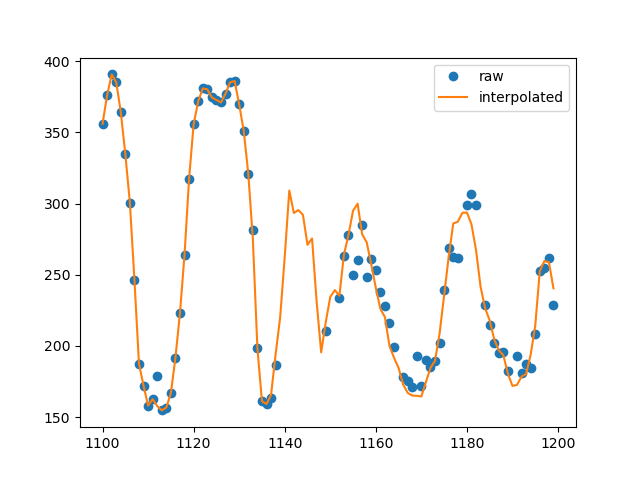

In [288]:
%matplotlib widget
gap_ind = np.arange(1100, 1200)

x = df_raw['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, 'o', label='raw')
x = df_interp['neuron_001']['x'].iloc[gap_ind]
plt.plot(x, label='interpolated')
plt.legend()

In [319]:
from DLC_for_WBFM.gui.utils.napari_trace_explorer import napari_trace_explorer
%gui qt

project_data.final_tracks = df_interp
napari_trace_explorer(project_data, False)

Starting GUI setup
Finished loading data, starting napari...


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/charles/a

Finished GUI setup
